In [2]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
import os
import datetime
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())

from IPython.display import Image
from time import sleep
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from pandas import DataFrame, Series
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from amb_sdk.sdk import DarwinSdk
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

# Cleaning Data

In [4]:
data = pd.read_csv("speed-dating_raw.csv")
x = ['gender', 'race', 'race_o', 'field']
columns = list(data)

# Deleting bins
for column in columns:
    if column not in x and data[str(column)].dtype.name == 'object':
        del data[str(column)]

# Deleting useless columns        
del data['has_null']
del data['wave']
del data['d_age']
del data['samerace']
del data['expected_happy_with_sd_people']
del data['expected_num_interested_in_me']
del data['expected_num_matches']
del data['like']
del data['guess_prob_liked']
del data['decision']
del data['decision_o']

# Replace age NA with mean
mean = round(data['age'].mean())
data['age'].fillna(mean, inplace = True)
mean = round(data['age_o'].mean())
data['age_o'].fillna(mean, inplace = True)

# Make sure difference in age is correct
data['age_d'] = (data['age'] - data['age_o'])
data['age_d_abs'] = data['age_d'].abs()

# Replace race NA with other
data['race'].fillna('other', inplace= True)
data['race_o'].fillna('other', inplace = True)

# Verifying that same_race is correct with replaced race
data['same_race'] = (data['race'] == data['race_o'])

# Replace NA with 0 for preferences
preferences = ['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests']          
for pref in preferences:
    data[pref].fillna(0, inplace = True)

# Renaming column names
data.rename(columns = {'importance_same_race':'same_race_i',
                       'importance_same_religion': 'same_religion_i',
                       'pref_o_attractive':'attractive_o_i',
                       'pref_o_sincere':'sincere_o_i',
                       'pref_o_intelligence':'intelligence_o_i',
                       'pref_o_funny':'funny_o_i',
                       'pref_o_ambitious':'ambitious_o_i',
                       'pref_o_shared_interests':'shared_interests_o_i',
                       'attractive_important':'attractive_i',
                       'sincere_important': 'sincere_i',
                       'intellicence_important': 'intelligence_i',
                       'funny_important':'funny_i',
                       'ambtition_important':'ambitious_i',
                       'shared_interests_important':'shared_interests_i',
                       'ambition':'ambitious',
                       'sinsere_o': 'sincere_o',
                       'ambitous_o':'ambitious_o',
                       'ambition_partner':'ambitious_partner'}, inplace = True)

# Making sure that opposite's importance columns add up to 100
data['o_i'] = data['attractive_o_i'] + data['sincere_o_i'] + data['intelligence_o_i'] + data['funny_o_i'] + data['ambitious_o_i'] + data['shared_interests_o_i']
data['attractive_o_i'] = (data['attractive_o_i'] / data['o_i'])
data['sincere_o_i'] = (data['sincere_o_i'] / data['o_i'])
data['intelligence_o_i'] = (data['intelligence_o_i'] / data['o_i'])
data['funny_o_i'] = (data['funny_o_i'] / data['o_i'])
data['ambitious_o_i'] = (data['ambitious_o_i'] / data['o_i'])
data['shared_interests_o_i'] = (data['shared_interests_o_i'] / data['o_i'])

# Making sure that my importance columns add up to 100
data['i'] = data['attractive_i'] + data['sincere_i'] + data['intelligence_i'] + data['funny_i'] + data['ambitious_i'] + data['shared_interests_i']
data['attractive_i'] = (data['attractive_i'] / data['i'])
data['sincere_i'] = (data['sincere_i'] / data['i'])
data['intelligence_i'] = (data['intelligence_i'] / data['i'])
data['funny_i'] = (data['funny_i'] / data['i'])
data['ambitious_i'] = (data['ambitious_i'] / data['i'])
data['shared_interests_i'] = (data['shared_interests_i'] / data['i'])

del data['o_i']
del data['i']

# Filling in data that are empty
temp = ['attractive_o_i', 'sincere_o_i', 'intelligence_o_i', 'funny_o_i', 'ambitious_o_i', 'shared_interests_o_i', 'attractive_i', 'sincere_i', 'intelligence_i', 'funny_i', 'ambitious_i', 'shared_interests_i']          
for t in temp:
    data[t].fillna((1.0 / 6.0), inplace = True)

# Replacing same_race_i & same_religion_i with mean (importance)
mean = data['same_race_i'].mean()
data['same_race_i'].fillna(round(mean), inplace = True)

mean = data['same_religion_i'].mean()
data['same_religion_i'].fillna(round(mean), inplace = True)

# One Hot Encoding of categorical data
data = pd.concat([data, pd.get_dummies(data['gender'], prefix = 'gender')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['race'], prefix = 'race')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['race_o'], prefix = 'race_o')], axis = 1)
data = pd.concat([data, pd.get_dummies(data['field'], prefix = 'field')], axis = 1)

del data['gender']
del data['race']
del data['race_o']
del data['field']

# Label Encoding
le = LabelEncoder()
data['same_race'] = le.fit_transform(data['same_race'])

# Fill NA's with mean
mean = data['attractive_o'].mean()
data['attractive_o'].fillna(round(mean), inplace = True)
mean = data['sincere_o'].mean()
data['sincere_o'].fillna(round(mean), inplace = True)
mean = data['intelligence_o'].mean()
data['intelligence_o'].fillna(round(mean), inplace = True)
mean = data['funny_o'].mean()
data['funny_o'].fillna(round(mean), inplace = True)
mean = data['ambitious_o'].mean()
data['ambitious_o'].fillna(round(mean), inplace = True)
mean = data['shared_interests_o'].mean()
data['shared_interests_o'].fillna(round(mean), inplace = True)
mean = data['attractive'].mean()
data['attractive'].fillna(round(mean), inplace = True)
mean = data['sincere'].mean()
data['sincere'].fillna(round(mean), inplace = True)
mean = data['intelligence'].mean()
data['intelligence'].fillna(round(mean), inplace = True)
mean = data['funny'].mean()
data['funny'].fillna(round(mean), inplace = True)
mean = data['ambitious'].mean()
data['ambitious'].fillna(round(mean), inplace = True)
mean = data['attractive_partner'].mean()
data['attractive_partner'].fillna(round(mean), inplace = True)
mean = data['sincere_partner'].mean()
data['sincere_partner'].fillna(round(mean), inplace = True)
mean = data['intelligence_partner'].mean()
data['intelligence_partner'].fillna(round(mean), inplace = True)
mean = data['funny_partner'].mean()
data['funny_partner'].fillna(round(mean), inplace = True)
mean = data['ambitious_partner'].mean()
data['ambitious_partner'].fillna(round(mean), inplace = True)
mean = data['shared_interests_partner'].mean()
data['shared_interests_partner'].fillna(round(mean), inplace = True)
mean = data['met'].mean()
data['met'].fillna(round(mean), inplace = True)

# Delete rows with NA's for interests correlate
data = data.dropna(axis = 0, subset = ['interests_correlate'])

print(data.shape)
data.head()

(8220, 287)


,age,age_o,same_race_i,same_religion_i,attractive_o_i,sincere_o_i,intelligence_o_i,funny_o_i,ambitious_o_i,shared_interests_o_i,...,field_tc [health ed],field_teaching of english,field_tesol,field_theater,field_theatre management & producing,field_theory,field_undergrad - gs,field_urban planning,field_working,field_writing: literary nonfiction
0,21.0,27.0,2.0,4.0,0.35,0.20,0.20,0.20,0.00,0.05,...,0,0,0,0,0,0,0,0,0,0
1,21.0,22.0,2.0,4.0,0.60,0.00,0.00,0.40,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
2,21.0,22.0,2.0,4.0,0.19,0.18,0.19,0.18,0.14,0.12,...,0,0,0,0,0,0,0,0,0,0
3,21.0,23.0,2.0,4.0,0.30,0.05,0.15,0.40,0.05,0.05,...,0,0,0,0,0,0,0,0,0,0
4,21.0,24.0,2.0,4.0,0.30,0.10,0.20,0.10,0.10,0.20,...,0,0,0,0,0,0,0,0,0,0


# Feature Engineering

In [5]:
# Difference between opposite's and my importance
data['attractive_i_d'] = (data['attractive_i'] - data['attractive_o_i'])
data['sincere_i_d'] = (data['sincere_i'] - data['sincere_o_i'])
data['intelligence_i_d'] = (data['intelligence_i'] - data['intelligence_o_i'])
data['funny_i_d'] = (data['funny_i'] - data['funny_o_i'])
data['ambitious_i_d'] = (data['ambitious_i'] - data['ambitious_o_i'])
data['shared_interests_i_d'] = (data['shared_interests_i'] - data['shared_interests_o_i'])

# Absolute difference of importance
data['attractive_i_d_abs'] = data['attractive_i_d'].abs()
data['sincere_i_d_abs'] = data['sincere_i_d'].abs()
data['intelligence_i_d_abs'] = data['intelligence_i_d'].abs()
data['funny_i_d_abs'] = data['funny_i_d'].abs()
data['ambitious_i_d_abs'] = data['ambitious_i_d'].abs()
data['shared_interests_i_d_abs'] = data['shared_interests_i_d'].abs()

# Difference between opposite's and my rating of me
data['attractive_d'] = (data['attractive'] - data['attractive_o'])
data['sincere_d'] = (data['sincere'] - data['sincere_o'])
data['intelligence_d'] = (data['intelligence'] - data['intelligence_o'])
data['funny_d'] = (data['funny'] - data['funny_o'])
data['ambitious_d'] = (data['ambitious'] - data['ambitious_o'])
data['shared_interests_d'] = (data['shared_interests_partner'] - data['shared_interests_o'])

# Absolute difference of rating
data['attractive_d_abs'] = data['attractive_d'].abs()
data['sincere_d_abs'] = data['sincere_d'].abs()
data['intelligence_d_abs'] = data['intelligence_d'].abs()
data['funny_d_abs'] = data['funny_d'].abs()
data['ambitious_d_abs'] = data['ambitious_d'].abs()
data['shared_interests_d_abs'] = data['shared_interests_d'].abs()

# Changing from [1-10] scale to percentage for opposite's rating
data['o'] = data['attractive_o'] + data['sincere_o'] + data['intelligence_o'] + data['funny_o'] + data['ambitious_o'] + data['shared_interests_o']
data['attractive_o_n'] = (data['attractive_o'] / data['o'])
data['sincere_o_n'] = (data['sincere_o'] / data['o'])
data['intelligence_o_n'] = (data['intelligence_o'] / data['o'])
data['funny_o_n'] = (data['funny_o'] / data['o'])
data['ambitious_o_n'] = (data['ambitious_o'] / data['o'])
data['shared_interests_o_n'] = (data['shared_interests_o'] / data['o'])

# Changing from [1-10] scale to percentage for my rating of opposite
data['p'] = data['attractive_partner'] + data['sincere_partner'] + data['intelligence_partner'] + data['funny_partner'] + data['ambitious_partner'] + data['shared_interests_partner']
data['attractive_p_n'] = (data['attractive_partner'] / data['p'])
data['sincere_p_n'] = (data['sincere_partner'] / data['p'])
data['intelligence_p_n'] = (data['intelligence_partner'] / data['p'])
data['funny_p_n'] = (data['funny_partner'] / data['p'])
data['ambitious_p_n'] = (data['ambitious_partner'] / data['p'])
data['shared_interests_p_n'] = (data['shared_interests_partner'] / data['p'])

del data['o']
del data['p']

# Filling in blanks with 0
preferences = ['attractive_o_n', 'sincere_o_n', 'intelligence_o_n', 'funny_o_n', 'ambitious_o_n', 'shared_interests_o_n', 'attractive_p_n', 'sincere_p_n', 'intelligence_p_n', 'funny_p_n', 'ambitious_p_n', 'shared_interests_p_n']
for pref in preferences:
    data[pref].fillna(0, inplace = True)

# Difference of rating percentage
data['d'] = data['attractive_d_abs'] + data['sincere_d_abs'] + data['intelligence_d_abs'] + data['funny_d_abs'] + data['ambitious_d_abs'] + data['shared_interests_d_abs']
data['attractive_d_n'] = (data['attractive_d'] / data['d'])
data['sincere_d_n'] = (data['sincere_d'] / data['d'])
data['intelligence_d_n'] = (data['intelligence_d'] / data['d'])
data['funny_d_n'] = (data['funny_d'] / data['d'])
data['ambitious_d_n'] = (data['ambitious_d'] / data['d'])
data['shared_interests_d_n'] = (data['shared_interests_d'] / data['d'])

del data['d']

# Absolute difference of rating percentage
data['attractive_d_n_abs'] = data['attractive_d_n'].abs()
data['sincere_d_n_abs'] = data['sincere_d_n'].abs()
data['intelligence_d_n_abs'] = data['intelligence_d_n'].abs()
data['funny_d_n_abs'] = data['funny_d_n'].abs()
data['ambitious_d_n_abs'] = data['ambitious_d_n'].abs()
data['shared_interests_d_n_abs'] = data['shared_interests_d_n'].abs()

# Difference between opposite's importance and their rating of me
data['attractive_oi_o_d_n'] = (data['attractive_o_i'] - data['attractive_o_n'])
data['sincere_oi_o_d_n'] = (data['sincere_o_i'] - data['sincere_o_n'])
data['intelligence_oi_o_d_n'] = (data['intelligence_o_i'] - data['intelligence_o_n'])
data['funny_oi_o_d_n'] = (data['funny_o_i'] - data['funny_o_n'])
data['ambitious_oi_o_d_n'] = (data['ambitious_o_i'] - data['ambitious_o_n'])
data['shared_interests_oi_o_d_n'] = (data['shared_interests_o_i'] - data['shared_interests_o_n'])

# Absolute difference of opposite's importance and their rating of me
data['attractive_oi_o_d_n_abs'] = data['attractive_oi_o_d_n'].abs()
data['sincere_oi_o_d_n_abs'] = data['sincere_oi_o_d_n'].abs()
data['intelligence_oi_o_d_n_abs'] = data['intelligence_oi_o_d_n'].abs()
data['funny_oi_o_d_n_abs'] = data['funny_oi_o_d_n'].abs()
data['ambitious_oi_o_d_n_abs'] = data['ambitious_oi_o_d_n'].abs()
data['shared_interests_oi_o_d_n_abs'] = data['shared_interests_oi_o_d_n'].abs()

# Difference between my importance and my rating of opposite
data['attractive_i_p_d_n'] = (data['attractive_i'] - data['attractive_p_n'])
data['sincere_i_p_d_n'] = (data['sincere_i'] - data['sincere_p_n'])
data['intelligence_i_p_d_n'] = (data['intelligence_i'] - data['intelligence_p_n'])
data['funny_i_p_d_n'] = (data['funny_i'] - data['funny_p_n'])
data['ambitious_i_p_d_n'] = (data['ambitious_i'] - data['ambitious_p_n'])
data['shared_interests_i_p_d_n'] = (data['shared_interests_i'] - data['shared_interests_p_n'])

# Absolute difference of my importance and my rating of opposite
data['attractive_i_p_d_n_abs'] = data['attractive_i_p_d_n'].abs()
data['sincere_i_p_d_n_abs'] = data['sincere_i_p_d_n'].abs()
data['intelligence_i_p_d_n_abs'] = data['intelligence_i_p_d_n'].abs()
data['funny_i_p_d_n_abs'] = data['funny_i_p_d_n'].abs()
data['ambitious_i_p_d_n_abs'] = data['ambitious_i_p_d_n'].abs()
data['shared_interests_i_p_d_n_abs'] = data['shared_interests_i_p_d_n'].abs()

# Changing from [1-10] scale to percentage for activities
data['a'] = data['sports'] + data['tvsports'] + data['exercise'] + data['dining'] + data['museums'] + data['art'] + data['hiking'] + data['gaming'] + data['clubbing'] + data['reading'] + data['tv'] + data['theater'] + data['movies'] + data['concerts'] + data['music'] + data['shopping'] + data['yoga']
data['sports_n'] = (data['sports'] / data['a']) 
data['tvsports_n'] = (data['tvsports'] / data['a']) 
data['exercise_n'] = (data['exercise'] / data['a']) 
data['dining_n'] = (data['dining'] / data['a']) 
data['museums_n'] = (data['museums'] / data['a']) 
data['art_n'] = (data['art'] / data['a']) 
data['hiking_n'] = (data['hiking'] / data['a']) 
data['gaming_n'] = (data['gaming'] / data['a']) 
data['clubbing_n'] = (data['clubbing'] / data['a']) 
data['reading_n'] = (data['reading'] / data['a']) 
data['tv_n'] = (data['tv'] / data['a']) 
data['theater_n'] = (data['theater'] / data['a']) 
data['movies_n'] = (data['movies'] / data['a']) 
data['concerts_n'] = (data['concerts'] / data['a']) 
data['music_n'] = (data['music'] / data['a']) 
data['shopping_n'] = (data['shopping'] / data['a']) 
data['yoga_n'] = (data['yoga'] / data['a']) 

del data['a']

data.to_csv('Speed_Dating_Clean_noSMOTE.csv', index = False)

# Create train and test data for Darwin (no SMOTE)
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.20, random_state = 11)
train_data = pd.concat([train_X, train_Y], axis = 1)
train_data.to_csv('Speed_Dating_Clean_noSMOTE_train.csv', index = False)
test_data = pd.concat([test_X, test_Y], axis = 1)
test_data.to_csv('Speed_Dating_Clean_noSMOTE_test.csv', index = False) 

# SMOTE

In [6]:
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

sm = SMOTE(sampling_strategy = 'minority', random_state = 11)
smote_X, smote_Y = sm.fit_sample(data_X, data_Y)

print(smote_X.shape)
print(smote_Y.shape)
smote_X = DataFrame(smote_X, columns = data_X.columns)
smote_Y = Series(smote_Y, name = 'match')
data = pd.concat([smote_X, smote_Y], axis = 1)
data.head()

data.to_csv('Speed_Dating_Clean_SMOTE.csv', index = False)

# Create train and test data for Darwin (SMOTE)
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)

train_X, test_X, train_Y, test_Y = train_test_split(data_X, data_Y, test_size = 0.20, random_state = 11)
train_data = pd.concat([train_X, train_Y], axis = 1)
train_data.to_csv('Speed_Dating_Clean_SMOTE_train.csv', index = False)
test_data = pd.concat([test_X, test_Y], axis = 1)
test_data.to_csv('Speed_Dating_Clean_SMOTE_test.csv', index = False) 

(13740, 375)
(13740,)


# Features and Label

In [7]:
data_Y = data['match']
data_X = data.drop(['match'], axis = 1)
print(data_X.shape)
data_X.head(5) 

(13740, 375)


,age,age_o,same_race_i,same_religion_i,attractive_o_i,sincere_o_i,intelligence_o_i,funny_o_i,ambitious_o_i,shared_interests_o_i,...,gaming_n,clubbing_n,reading_n,tv_n,theater_n,movies_n,concerts_n,music_n,shopping_n,yoga_n
0,21.0,27.0,2.0,4.0,0.35,0.20,0.20,0.20,0.00,0.05,...,0.010526,0.052632,0.063158,0.094737,0.010526,0.105263,0.105263,0.094737,0.084211,0.010526
1,21.0,22.0,2.0,4.0,0.60,0.00,0.00,0.40,0.00,0.00,...,0.010526,0.052632,0.063158,0.094737,0.010526,0.105263,0.105263,0.094737,0.084211,0.010526
2,21.0,22.0,2.0,4.0,0.19,0.18,0.19,0.18,0.14,0.12,...,0.010526,0.052632,0.063158,0.094737,0.010526,0.105263,0.105263,0.094737,0.084211,0.010526
3,21.0,23.0,2.0,4.0,0.30,0.05,0.15,0.40,0.05,0.05,...,0.010526,0.052632,0.063158,0.094737,0.010526,0.105263,0.105263,0.094737,0.084211,0.010526
4,21.0,24.0,2.0,4.0,0.30,0.10,0.20,0.10,0.10,0.20,...,0.010526,0.052632,0.063158,0.094737,0.010526,0.105263,0.105263,0.094737,0.084211,0.010526


# Decision Tree

In [12]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = DecisionTreeClassifier(random_state = 11)

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__criterion" : ['gini', 'entropy'],
          "clf__max_depth": [15, 20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [5, 10, 15]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 10)
grid_search.fit(X_train, Y_train)

# Print results
print(grid_search.best_params_)
print("Accuracy on Train Data is :", grid_search.best_score_ * 100)

# Print Test Accuracy
preds = grid_search.predict(X_test)
print('Accuracy on Test data is:', (accuracy_score(Y_test, preds))*100)


# Print classification report
print("Classification Report for Test Data")
print("\n", classification_report(Y_test, grid_search.predict(X_test)))

{'clf__criterion': 'entropy', 'clf__max_depth': 30, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5}
Accuracy on Train Data is : 77.56550218340611
Accuracy on Test data is: 0.7783842794759825

               precision    recall  f1-score   support

           0       0.79      0.76      0.78      1377
           1       0.77      0.79      0.78      1371

   micro avg       0.78      0.78      0.78      2748
   macro avg       0.78      0.78      0.78      2748
weighted avg       0.78      0.78      0.78      2748

CPU times: user 10min 25s, sys: 17.6 s, total: 10min 43s
Wall time: 5min 39s


# Random Forest

In [25]:
%%time

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = RandomForestClassifier(random_state = 11, n_estimators = 100)

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Set parameters
params = {"clf__criterion" : ['gini', 'entropy'],
          "clf__max_depth": [15, 20, 25, 30, 35],
          "clf__max_features": ['sqrt', 'log2'],
          "clf__min_samples_leaf": [5, 10, 15]
         }

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 10)
grid_search.fit(X_train, Y_train)

# Print results
print(grid_search.best_params_)
print("Accuracy on Train Data is :", grid_search.best_score_ * 100)

# Print Test Accuracy
preds = grid_search.predict(X_test)
print('Accuracy on Test data is:', (accuracy_score(Y_test, preds))*100)


# Print classification report
print("Classification Report for Test Data")
print("\n", classification_report(Y_test, grid_search.predict(X_test)))

{'clf__criterion': 'entropy', 'clf__max_depth': 35, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5}
Accuracy on Train Data is : 90.06550218340611
Accuracy on Test data is: 90.5749636098981
Classification Report for Test Data

               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1394
           1       0.90      0.92      0.91      1354

   micro avg       0.91      0.91      0.91      2748
   macro avg       0.91      0.91      0.91      2748
weighted avg       0.91      0.91      0.91      2748

CPU times: user 1h 54min 49s, sys: 40.3 s, total: 1h 55min 29s
Wall time: 15h 56min 22s


# AdaBoost

In [26]:
%%time

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = AdaBoostClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Pass the pipeline in to a cross_val_score and Output Training Accuracy 
scores = cross_val_score(pipe, data_X, data_Y, cv = 5)
print("Accuracy with 5-fold cross validation on Training Data:", scores.mean() * 100)

# Fit the model to the Training Data
pipe.fit(X_train, Y_train)

# Print Accuracy, Confusion matrix and Classification report for Test Data
pred_Y = cross_val_predict(clf_rf, X_test, Y_test, cv = 10)
print("Accuracy with 10-fold cross validation on Test Data:",accuracy_score(Y_test, pred_Y)*100)
print()
print('The confusion matrix is:\n', confusion_matrix(Y_test, pred_Y))
print('\n', classification_report(Y_test, pred_Y))

Accuracy with 5-fold cross validation on Training Data: 73.33333333333333
Accuracy with 10-fold cross validation on Test Data: 55.74963609898108

The confusion matrix is:
 [[ 293 1124]
 [  92 1239]]

               precision    recall  f1-score   support

           0       0.76      0.21      0.33      1417
           1       0.52      0.93      0.67      1331

   micro avg       0.56      0.56      0.56      2748
   macro avg       0.64      0.57      0.50      2748
weighted avg       0.65      0.56      0.49      2748

CPU times: user 3min, sys: 1.15 s, total: 3min 1s
Wall time: 3min 4s


# GradientBoosting

In [27]:
%%time

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

scaler = StandardScaler()
pca = PCA(0.95, random_state = 11)
clf = GradientBoostingClassifier(random_state = 11, n_estimators = 100)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('clf', clf)])

# Pass the pipeline in to a cross_val_score and Output Training Accuracy 
scores = cross_val_score(pipe, data_X, data_Y, cv = 5)
print("Accuracy with 5-fold cross validation on Training Data:", scores.mean() * 100)

# Fit the model to the Training Data
pipe.fit(X_train, Y_train)

# Print Accuracy, Confusion matrix and Classification report for Test Data
pred_Y = cross_val_predict(clf_rf, X_test, Y_test, cv = 10)
print("Accuracy with 10-fold cross validation on Test Data:",accuracy_score(Y_test, pred_Y)*100)
print()
print('The confusion matrix is:\n', confusion_matrix(Y_test, pred_Y))
print('\n', classification_report(Y_test, pred_Y))

Accuracy with 5-fold cross validation on Training Data: 75.02911208151384
Accuracy with 10-fold cross validation on Test Data: 57.49636098981077

The confusion matrix is:
 [[ 291 1071]
 [  97 1289]]

               precision    recall  f1-score   support

           0       0.75      0.21      0.33      1362
           1       0.55      0.93      0.69      1386

   micro avg       0.57      0.57      0.57      2748
   macro avg       0.65      0.57      0.51      2748
weighted avg       0.65      0.57      0.51      2748

CPU times: user 2min 10s, sys: 570 ms, total: 2min 11s
Wall time: 2min 10s


# KNN

In [28]:
%%time

scaler = MinMaxScaler()
pca = PCA(0.95, random_state = 11)
knn = KNeighborsClassifier()

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('pca', pca), ('knn', knn)])

# Set parameters
params = {'knn__n_neighbors': [3, 4, 5]}

# Find best parameters
grid_search = GridSearchCV(pipe, params, cv = 10)
grid_search.fit(X_train, Y_train)

# Print results
print(grid_search.best_params_)
print("Accuracy on Train Data is :", grid_search.best_score_ * 100)

# Print Test Accuracy
preds = grid_search.predict(X_test)
print('Accuracy on Test data is:', (accuracy_score(Y_test, preds))*100)


# Print classification report
print("Classification Report for Test Data")
print("\n", classification_report(Y_test, grid_search.predict(X_test)))

{'knn__n_neighbors': 4}
Accuracy on Train Data is : 83.9519650655022
Accuracy on Test data is: 84.49781659388647
Classification Report for Test Data

               precision    recall  f1-score   support

           0       0.92      0.76      0.83      1362
           1       0.80      0.93      0.86      1386

   micro avg       0.84      0.84      0.84      2748
   macro avg       0.86      0.84      0.84      2748
weighted avg       0.86      0.84      0.84      2748

CPU times: user 8min 42s, sys: 1.4 s, total: 8min 43s
Wall time: 8min 23s


# SVM

In [24]:
%%time

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

scaler = StandardScaler()

# Creating svc. Here we use the default instead of linear as mentioned on the piazza post. 
svc_clf = SVC(random_state = 11)

# Creating the pipeline
pipe = Pipeline(steps = [('sca', scaler ), ('svc', svc_clf)])

# Pass the pipeline in to a cross_val_score and Output Training Accuracy 
scores = cross_val_score(pipe, data_X, data_Y, cv = 5)
print("Accuracy with 5-fold cross validation on Training Data:", scores.mean() * 100)


# Fit the model to the Training Data
pipe.fit(X_train, Y_train)

# Print Accuracy, Confusion matrix and Classification report for Test Data
pred_Y = cross_val_predict(clf_rf, X_test, Y_test, cv = 10)
print("Accuracy with 10-fold cross validation on Test Data:",accuracy_score(Y_test, pred_Y)*100)
print()
print('The confusion matrix is:\n', confusion_matrix(Y_test, pred_Y))
print('\n', classification_report(Y_test, pred_Y))

Accuracy with 5-fold cross validation on Training Data: 72.90393013100437
Accuracy with 10-fold cross validation on Test Data: 57.38719068413391

The confusion matrix is:
 [[ 298 1084]
 [  87 1279]]

               precision    recall  f1-score   support

           0       0.77      0.22      0.34      1382
           1       0.54      0.94      0.69      1366

   micro avg       0.57      0.57      0.57      2748
   macro avg       0.66      0.58      0.51      2748
weighted avg       0.66      0.57      0.51      2748

CPU times: user 3min 37s, sys: 1.47 s, total: 3min 39s
Wall time: 3min 40s


# Naive Bayes

In [23]:
%%time

# Create NB clf and fit it
clf_rf = GaussianNB()

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

# Output Accuracy of Training Data
scores = cross_val_score(clf_rf, X_train, Y_train, cv = 10)  
print("Accuracy with 10-fold cross validation on Training Data:", scores.mean() * 100)

# Fit the model to the Training Data
clf_rf.fit(X_train, Y_train)

# Print Accuracy, Confusion matrix and Classification report for Test Data
pred_Y = cross_val_predict(clf_rf, X_test, Y_test, cv = 10)
print("Accuracy with 10-fold cross validation on Test Data:",accuracy_score(Y_test, pred_Y)*100)
print()
print('The confusion matrix is:\n', confusion_matrix(Y_test, pred_Y))
print('\n', classification_report(Y_test, pred_Y))

Accuracy with 10-fold cross validation on Training Data: 57.64216334063086
Accuracy with 10-fold cross validation on Test Data: 59.20669577874818

The confusion matrix is:
 [[ 330 1029]
 [  92 1297]]

               precision    recall  f1-score   support

           0       0.78      0.24      0.37      1359
           1       0.56      0.93      0.70      1389

   micro avg       0.59      0.59      0.59      2748
   macro avg       0.67      0.59      0.53      2748
weighted avg       0.67      0.59      0.54      2748

CPU times: user 1.07 s, sys: 179 ms, total: 1.25 s
Wall time: 1.26 s


# Neural Networks

In [9]:
%%time

# Create Train and Test Split
X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.2)

scaler = StandardScaler()
clf = MLPClassifier(random_state = 11)

# Create pipeline
pipe = Pipeline(steps = [('scaler', scaler), ('clf', clf)])

# Set parameters
param_grid = {
    'clf__hidden_layer_sizes': [(50,), (60,), (70,), (80,), (90,), (100,)],
    'clf__activation': ['identity', 'logistic', 'tanh', 'relu']
}

# Find best parameters
grid_search = GridSearchCV(pipe, param_grid, iid = False, cv = 5)
grid_search.fit(X_train, Y_train)


# Print results
print(grid_search.best_params_)
print("Accuracy on Train Data is :", grid_search.best_score_ * 100)

# Print Test Accuracy
preds = grid_search.predict(X_test)
print('Accuracy on Test data is:', (accuracy_score(Y_test, preds))*100)


# Print classification report
print("Classification Report for Test Data")
print("\n", classification_report(Y_test, grid_search.predict(X_test)))

{'clf__activation': 'relu', 'clf__hidden_layer_sizes': (80,)}
Accuracy on Train Data is : 92.84934237736785
Accuracy on Test data is: 94.14119359534206
Classification Report for Test Data

               precision    recall  f1-score   support

           0       0.97      0.91      0.94      1369
           1       0.91      0.97      0.94      1379

   micro avg       0.94      0.94      0.94      2748
   macro avg       0.94      0.94      0.94      2748
weighted avg       0.94      0.94      0.94      2748

CPU times: user 24min 59s, sys: 29.2 s, total: 25min 28s
Wall time: 12min 50s


# Darwin (SMOTE)

In [11]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('EMMIECHNG@UTEXAS.EDU', 'QMCZgepW6u')

if not status:
    print(msg)

In [12]:
dataset_train = 'Speed_Dating_Clean_SMOTE_train.csv'
dataset_test = 'Speed_Dating_Clean_SMOTE_test.csv'

**Upload datasets**

In [13]:
# Upload train dataset to Darwin
data_SMOTE_train = pd.read_csv("Speed_Dating_Clean_SMOTE_train.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_SMOTE_train.csv")

if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



In [14]:
# Upload test dataset to Darwin
data_SMOTE_test = pd.read_csv("Speed_Dating_Clean_SMOTE_test.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_SMOTE_test.csv")

if not status:
    print(dataset)

400: BAD REQUEST - {"message": "Dataset already exists"}



In [15]:
ds.lookup_dataset()

(True,
 [{'name': 'Speed_Dating_Clean_SMOTE_train.csv',
   'mbytes': 30.262596130371094,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-19T10:56:59.192746',
   'categorical': None,
   'sequential': None,
   'imbalanced': None},
  {'name': 'Speed_Dating_Clean_SMOTE_test.csv',
   'mbytes': 7.55277156829834,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-19T10:57:36.206237',
   'categorical': None,
   'sequential': None,
   'imbalanced': None}])

**Clean datasets**

In [16]:
# Clean train dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_train, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-19T17:14:47.546333', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['70ddaa32af0a46ac8906a6efdfdab1c0'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:14:47.546333', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['70ddaa32af0a46ac8906a6efdfdab1c0'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:14:47.546333', 'endtime': '2019-04-19T17:15:18.999838', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['70ddaa32af0a46ac8906a6efdfdab1c0'], 'model_name': None, 'job_error': ''}


In [17]:
# Clean test dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_test, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-19T17:15:20.289154', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['2e823c0de9c64db8877d4f3a71cc61cd'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:15:20.289154', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['2e823c0de9c64db8877d4f3a71cc61cd'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:15:20.289154', 'endtime': '2019-04-19T17:15:35.743198', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['2e823c0de9c64db8877d4f3a71cc61cd'], 'model_name': None, 'job_error': ''}


**Create model**

In [18]:
# Create Darwin model
model = target + "_model" + ts
status, job_id = ds.create_model(dataset_names = dataset_train,
                                 model_name = model,
                                 max_train_time = '00:05')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-19T17:15:53.325031', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:15:53.325031', 'endtime': None, 'percent_complete': 1, 'job_type': 'TrainModel', 'loss': 0.42760908603668213, 'generations': 0, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:15:53.325031', 'endtime': None, 'percent_complete': 5, 'job_type': 'TrainModel', 'loss': 0.4154246151447296, 'generations': 1, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:15:53.325

In [19]:
# Extra training for Darwin model
status, job_id = ds.resume_training_model(dataset_names = dataset_train, 
                                         model_name = model,
                                         max_train_time = '00:05')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-19T17:21:33.329789', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.33944851491186356, 'generations': 4, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190419165435', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-19T17:21:33.329789', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.33944851491186356, 'generations': 4, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:21:33.329789', 'endtime': None, 'percent_complete': 3, 'job_type': 'UpdateModel', 'loss': 0.33944851491186356, 'generations': 6, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': None, 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '

# Best model decided by Darwin

**Analyze model**

In [20]:
# Analyze Darwin model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-19T17:28:00.414216', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['e9a3b7e0c45e4225a4985bf7c9c27fd5'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:28:00.414216', 'endtime': '2019-04-19T17:28:04.986357', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['e9a3b7e0c45e4225a4985bf7c9c27fd5'], 'model_name': 'match_model20190419165435', 'job_error': ''}


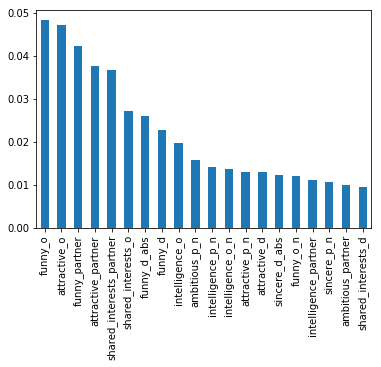

In [21]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [22]:
status, artifact = ds.run_model(dataset_train, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:28:19.534705', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['5b5bd85e513f41e89ef412e969790345'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:28:19.534705', 'endtime': '2019-04-19T17:28:22.843299', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['5b5bd85e513f41e89ef412e969790345'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0        prob_1
0      1  0.000285  9.997154e-01
1      1  0.002327  9.976732e-01
2      0  1.000000  2.387000e-07
3      1  0.020747  9.792534e-01
4      0  0.999821  1.793346e-04


**Create plots comparing predictions with actual target**

R^2 :  0.9308587972487067


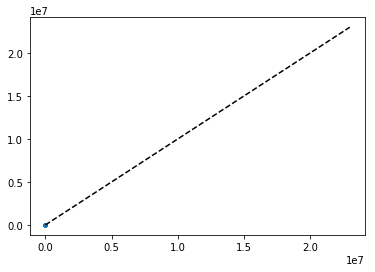

In [23]:
plt.plot(data_SMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_train[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5494
           1       0.98      0.99      0.98      5498

   micro avg       0.98      0.98      0.98     10992
   macro avg       0.98      0.98      0.98     10992
weighted avg       0.98      0.98      0.98     10992



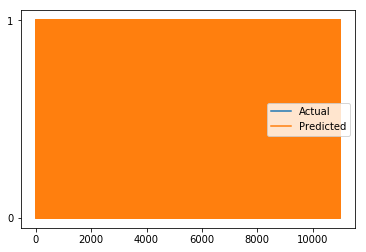

In [24]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [25]:
status, artifact = ds.run_model(dataset_test, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:28:42.082842', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d71a6c65b15a4a6a918094ab4e599a00'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:28:42.082842', 'endtime': '2019-04-19T17:28:44.315885', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d71a6c65b15a4a6a918094ab4e599a00'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0        prob_1
0      0  1.000000  1.000000e-10
1      0  0.998388  1.611901e-03
2      0  0.973286  2.671351e-02
3      1  0.342260  6.577402e-01
4      1  0.013292  9.867084e-01


**Create plots comparing predictions with actual target**

R^2 :  -0.43522865957014045


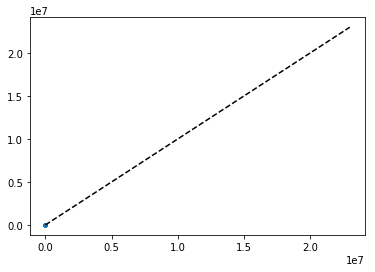

In [26]:
plt.plot(data_SMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_test[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.61      0.80      0.69      1376
           1       0.70      0.49      0.58      1372

   micro avg       0.64      0.64      0.64      2748
   macro avg       0.66      0.64      0.63      2748
weighted avg       0.66      0.64      0.63      2748



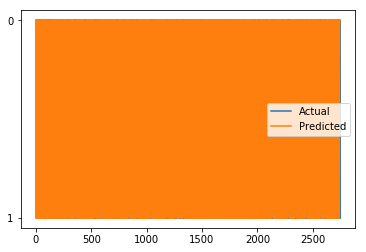

In [27]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

**Model Darwin used**

In [28]:
status, model_type = ds.lookup_model_name(model)
print(model_type)

{'type': 'Supervised', 'updated_at': '2019-04-19T17:27:43.997536', 'trained_on': ['Speed_Dating_Clean_SMOTE_train.csv'], 'loss': 0.33944851491186356, 'generations': 7, 'parameters': {'train_time': '00:05', 'target': 'match', 'recurrent': False, 'max_unique_values': 50, 'max_int_uniques': 15, 'impute': 'mean', 'big_data': False}, 'description': {'best_genome': [{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 286}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 256}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'identity', 'numunits': 2}}}], 'recurrent': False, 'genome_type': 'DeepNet'}, 'train_time_seconds': 327, 'algorithm': None, 'running_job_id': None}


In [29]:
ds.display_population(model)

(True,
 {'population': {'model_types': {'DeepNeuralNetwork': {'model_description': [{'layer 1': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 286}}},
      {'layer 2': {'type': 'LinearGene',
        'parameters': {'activation': 'relu', 'numunits': 256}}},
      {'layer 3': {'type': 'LinearGene',
        'parameters': {'activation': 'identity', 'numunits': 2}}}],
     'loss_function': 'CrossEntropy',
     'fitness': 1.9367051372066848},
    'RandomForest': {'model_description': {'type': 'RandomForestClassifier',
      'parameters': {'bootstrap': False,
       'criterion': 'entropy',
       'max_depth': 9,
       'max_features': 0.8944781178477494,
       'max_leaf_nodes': None,
       'min_impurity_decrease': 0.0,
       'min_samples_leaf': 10,
       'min_samples_split': 6,
       'n_jobs': -1,
       'min_weight_fraction_leaf': 0.0,
       'n_estimators': 353}},
     'loss_function': 'CrossEntropy',
     'fitness': 1.8717493155180842},
    'GradientBo

# DeepNeuralNetwork

**Analyze DeepNeuralNetwork model**

In [30]:
# Analyze Darwin DeepNeuralNetwork model
status, artifact = ds.analyze_model(model, model_type = 'DeepNeuralNetwork')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-19T17:29:03.022832', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['146d558b0ec64dc5a9e9084611267962'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:29:03.022832', 'endtime': '2019-04-19T17:29:07.043512', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['146d558b0ec64dc5a9e9084611267962'], 'model_name': 'match_model20190419165435', 'job_error': ''}


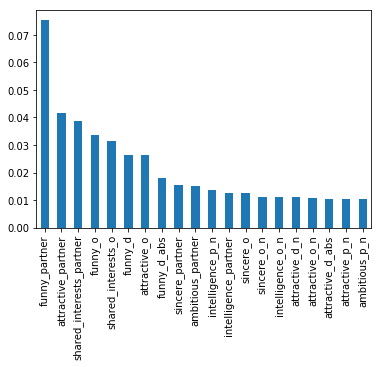

In [31]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [32]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:29:21.932419', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['2e0f52dc82a748c4b737e1ee635f5481'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:29:21.932419', 'endtime': '2019-04-19T17:29:25.966503', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['2e0f52dc82a748c4b737e1ee635f5481'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0        prob_1
0      1  0.000285  9.997154e-01
1      1  0.002327  9.976732e-01
2      0  1.000000  2.387000e-07
3      1  0.020747  9.792534e-01
4      0  0.999821  1.793346e-04


**Create plots comparing predictions with actual target**

R^2 :  0.9308587972487067


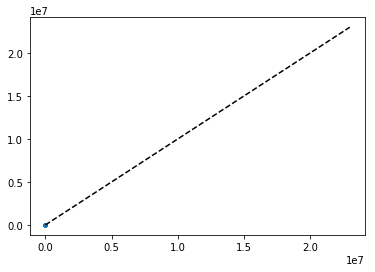

In [33]:
plt.plot(data_SMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_train[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.99      0.98      0.98      5494
           1       0.98      0.99      0.98      5498

   micro avg       0.98      0.98      0.98     10992
   macro avg       0.98      0.98      0.98     10992
weighted avg       0.98      0.98      0.98     10992



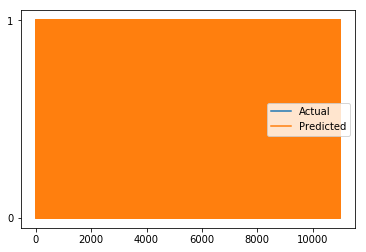

In [34]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [35]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:29:43.628371', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['fb0effb5fe4a4d20a1ec6af65268c88e'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:29:43.628371', 'endtime': '2019-04-19T17:29:52.360582', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['fb0effb5fe4a4d20a1ec6af65268c88e'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0        prob_1
0      0  1.000000  1.000000e-10
1      0  0.998388  1.611901e-03
2      0  0.973286  2.671351e-02
3      1  0.342260  6.577402e-01
4      1  0.013292  9.867084e-01


**Create plots comparing predictions with actual target**

R^2 :  -0.43522865957014045


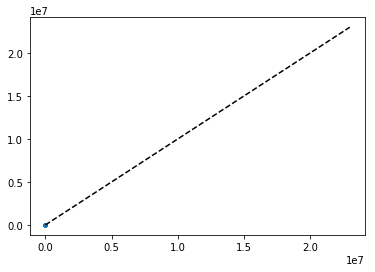

In [36]:
plt.plot(data_SMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_test[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.61      0.80      0.69      1376
           1       0.70      0.49      0.58      1372

   micro avg       0.64      0.64      0.64      2748
   macro avg       0.66      0.64      0.63      2748
weighted avg       0.66      0.64      0.63      2748



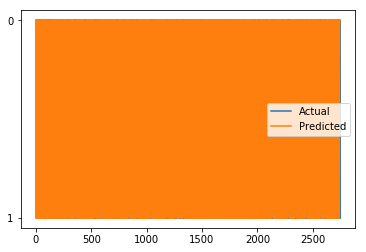

In [37]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# RandomForest

**Analyze RandomForest model**

In [38]:
# Analyze Darwin RandomForest model
status, artifact = ds.analyze_model(model, model_type = 'RandomForest')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-19T17:30:03.739943', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['916b6002b06b4193bc677f5bd74121ce'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:30:03.739943', 'endtime': '2019-04-19T17:30:10.284573', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['916b6002b06b4193bc677f5bd74121ce'], 'model_name': 'match_model20190419165435', 'job_error': ''}


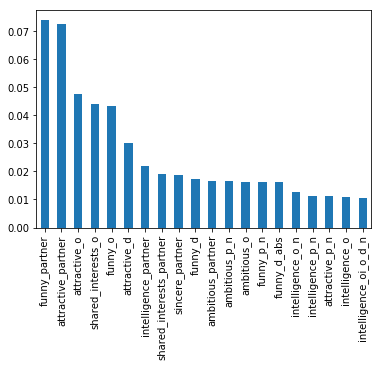

In [39]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [40]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:30:22.907141', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['2ce779b45463476b8bc7fc1f423dd211'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:30:22.907141', 'endtime': '2019-04-19T17:30:29.081614', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['2ce779b45463476b8bc7fc1f423dd211'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.013504  0.986496
1      1  0.019723  0.980277
2      1  0.486802  0.513198
3      0  0.579160  0.420840
4      1  0.386598  0.613402


**Create plots comparing predictions with actual target**

R^2 :  0.6393740424919385


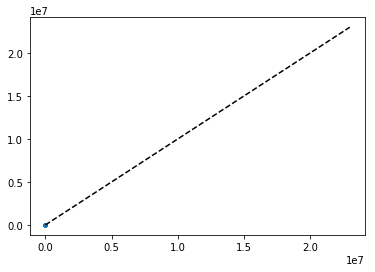

In [41]:
plt.plot(data_SMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_train[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.92      0.90      0.91      5494
           1       0.90      0.92      0.91      5498

   micro avg       0.91      0.91      0.91     10992
   macro avg       0.91      0.91      0.91     10992
weighted avg       0.91      0.91      0.91     10992



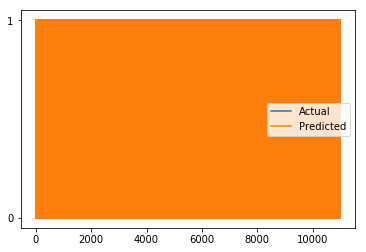

In [42]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [43]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:30:45.428915', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['0348852c626640ec84abeb05e908770e'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:30:45.428915', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['0348852c626640ec84abeb05e908770e'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T17:30:45.428915', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['0348852c626640ec84abeb05e908770e'], 'model_name': 'm

**Create plots comparing predictions with actual target**

R^2 :  -0.03639229778290076


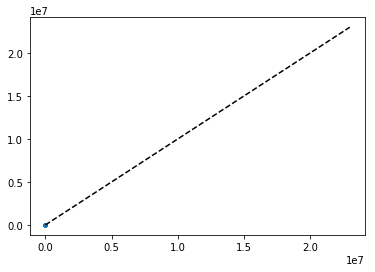

In [44]:
plt.plot(data_SMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_test[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.87      0.56      0.69      1376
           1       0.68      0.92      0.78      1372

   micro avg       0.74      0.74      0.74      2748
   macro avg       0.78      0.74      0.73      2748
weighted avg       0.78      0.74      0.73      2748



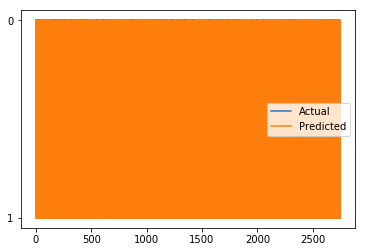

In [45]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# GradientBoosted

**Analyze GradientBoosted model**

In [46]:
# Analyze Darwin GradientBoosted model
status, artifact = ds.analyze_model(model, model_type = 'GradientBoosted')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-19T17:32:09.503279', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['14daf2cf2c454a0cbec92eac9ff34686'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:32:09.503279', 'endtime': '2019-04-19T17:32:13.635143', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': None, 'artifact_names': ['14daf2cf2c454a0cbec92eac9ff34686'], 'model_name': 'match_model20190419165435', 'job_error': ''}


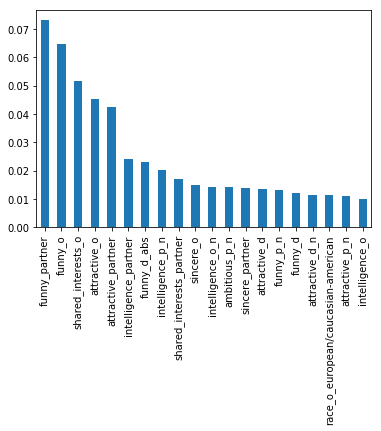

In [47]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [48]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:32:28.978059', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['b02a5deaf1b841e89a590db07ee13d8c'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:32:28.978059', 'endtime': '2019-04-19T17:32:32.716462', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_train.csv'], 'artifact_names': ['b02a5deaf1b841e89a590db07ee13d8c'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.027765  0.972235
1      1  0.049070  0.950930
2      0  0.744642  0.255358
3      0  0.509461  0.490539
4      0  0.811886  0.188114


**Create plots comparing predictions with actual target**

R^2 :  0.7212517825921543


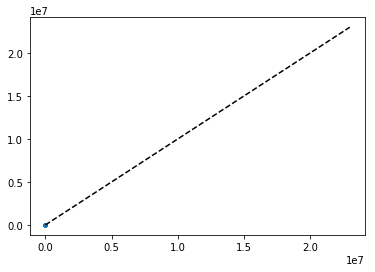

In [49]:
plt.plot(data_SMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_train[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.91      0.95      0.93      5494
           1       0.95      0.91      0.93      5498

   micro avg       0.93      0.93      0.93     10992
   macro avg       0.93      0.93      0.93     10992
weighted avg       0.93      0.93      0.93     10992



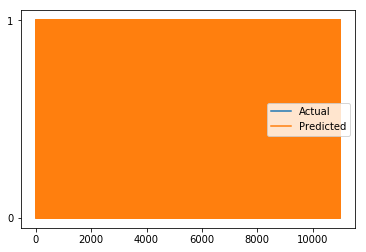

In [50]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [51]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

{'status': 'Running', 'starttime': '2019-04-19T17:32:51.505047', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d597f4aba51a47ab8119a9ea3c8c436c'], 'model_name': 'match_model20190419165435', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T17:32:51.505047', 'endtime': '2019-04-19T17:32:53.11165', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.33944851491186356, 'generations': 7, 'dataset_names': ['Speed_Dating_Clean_SMOTE_test.csv'], 'artifact_names': ['d597f4aba51a47ab8119a9ea3c8c436c'], 'model_name': 'match_model20190419165435', 'job_error': ''}

    match    prob_0    prob_1
0      1  0.343774  0.656226
1      1  0.005935  0.994065
2      1  0.003412  0.996588
3      1  0.000848  0.999152
4      0  0.766103  0.233897


**Create plots comparing predictions with actual target**

R^2 :  -0.6448360905824126


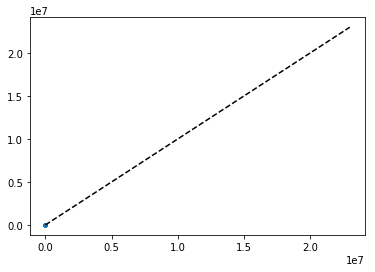

In [52]:
plt.plot(data_SMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_SMOTE_test[target], prediction[target]))


               precision    recall  f1-score   support

           0       0.97      0.18      0.31      1376
           1       0.55      0.99      0.71      1372

   micro avg       0.59      0.59      0.59      2748
   macro avg       0.76      0.59      0.51      2748
weighted avg       0.76      0.59      0.51      2748



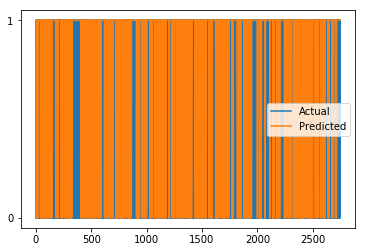

In [53]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_SMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_SMOTE_test[target], prediction[target]))

# Darwin (noSMOTE) : imbalanced data

In [54]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('EMMIECHNG@UTEXAS.EDU', 'QMCZgepW6u')

if not status:
    print(msg)

In [55]:
dataset_train = 'Speed_Dating_Clean_noSMOTE_train.csv'
dataset_test = 'Speed_Dating_Clean_noSMOTE_test.csv'

**Upload datasets**

In [56]:
# Upload train dataset to Darwin
data_noSMOTE_train = pd.read_csv("Speed_Dating_Clean_noSMOTE_train.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_noSMOTE_train.csv")

if not status:
    print(dataset)

In [57]:
# Upload test dataset to Darwin
data_noSMOTE_test = pd.read_csv("Speed_Dating_Clean_noSMOTE_test.csv")
status, dataset = ds.upload_dataset("Speed_Dating_Clean_noSMOTE_test.csv")

if not status:
    print(dataset)

In [58]:
ds.lookup_dataset()

(True,
 [{'name': 'Speed_Dating_Clean_noSMOTE_test.csv',
   'mbytes': 3.317239761352539,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-19T17:33:48.101729',
   'categorical': None,
   'sequential': None,
   'imbalanced': None},
  {'name': 'Speed_Dating_Clean_noSMOTE_train.csv',
   'mbytes': 13.215371131896973,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-19T17:33:42.724174',
   'categorical': None,
   'sequential': None,
   'imbalanced': None},
  {'name': 'Speed_Dating_Clean_SMOTE_train.csv',
   'mbytes': 30.262596130371094,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-19T10:56:59.192746',
   'categorical': None,
   'sequential': None,
   'imbalanced': None},
  {'name': 'Speed_Dating_Clean_SMOTE_test.csv',
   'mbytes': 7.55277156829834,
   'minimum_recommeded_train_time': '5 minutes',
   'updated_at': '2019-04-19T10:57:36.206237',
   'categorical': None,
   'sequential': None,
   'imbalanced': None}

**Clean datasets**

In [ ]:
# Clean train dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_train, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

In [ ]:
# Clean test dataset on Darwin
target = "match"
status, job_id = ds.clean_data(dataset_test, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

**Create model**

In [ ]:
# Create Darwin model
model = target + "_model_noSMOTE" + ts
status, job_id = ds.create_model(dataset_names = dataset_train,
                                 model_name = model,
                                 max_train_time = '00:05')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

In [ ]:
# Extra training for Darwin model
status, job_id = ds.resume_training_model(dataset_names = dataset_train, 
                                         model_name = model,
                                         max_train_time = '00:05')

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

# Best model decided by Darwin

**Analyze model**

In [ ]:
# Analyze Darwin model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

In [ ]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [ ]:
status, artifact = ds.run_model(dataset_train, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_train[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [ ]:
status, artifact = ds.run_model(dataset_test, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_test[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_test[target], prediction[target]))

**Model Darwin used**

In [ ]:
status, model_type = ds.lookup_model_name(model)
print(model_type)

In [ ]:
ds.display_population(model)

# DeepNeuralNetwork

**Analyze DeepNeuralNetwork model**

In [ ]:
# Analyze Darwin DeepNeuralNetwork model
status, artifact = ds.analyze_model(model, model_type = 'DeepNeuralNetwork')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

In [ ]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [ ]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_train[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [ ]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'DeepNeuralNetwork')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_test[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_test[target], prediction[target]))

# RandomForest

**Analyze RandomForest model**

In [ ]:
# Analyze Darwin RandomForest model
status, artifact = ds.analyze_model(model, model_type = 'RandomForest')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

In [ ]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [ ]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_train[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [ ]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'RandomForest')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_test[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_test[target], prediction[target]))

# GradientBoosted

**Analyze GradientBoosted model**

In [ ]:
# Analyze Darwin GradientBoosted model
status, artifact = ds.analyze_model(model, model_type = 'GradientBoosted')
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

In [ ]:
feature_importance[:20].plot.bar()

**Prediction on training dataset**

In [ ]:
status, artifact = ds.run_model(dataset_train, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_train[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_train[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_train[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_train[target], prediction[target]))

**Prediction on testing data**

In [ ]:
status, artifact = ds.run_model(dataset_test, model, model_type = 'GradientBoosted')
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
print("\n", prediction.head())

**Create plots comparing predictions with actual target**

In [ ]:
plt.plot(data_noSMOTE_test[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
print('R^2 : ', r2_score(data_noSMOTE_test[target], prediction[target]))

In [ ]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(data_noSMOTE_test[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print("\n", classification_report(data_noSMOTE_test[target], prediction[target]))